### R-group Analysis
In this notebook, we will use an R-group decomposition to perform exploratory data analysis on a dataset from the ChEMBL database. We will define a common scaffold for a set of molecules and use the function [rdRGroupDecomposition.RGroupDecompose](https://www.rdkit.org/docs/source/rdkit.Chem.rdRGroupDecomposition.html) from the RDKit to create a table of substituents attached at different positions on the scaffold. To perform this analysis, we will carry out the following steps.

- Read the input data from a SMILES file
- Cluster the input data to identify similar molecules
- View the largest cluster and identify the common scaffold
- Perform the R-group decomposition
- View the R-groups and their frequency


#### Setup
Install the necessary Python packages

In [1]:
!pip install useful_rdkit_utils mols2grid

Import the necessary Python packages

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRGroupDecomposition
import pandas as pd
import mols2grid
import useful_rdkit_utils as uru
from ipywidgets import interact

#### Read the Input Data
We begin by reading a set of molecules from a csv file.  The csv file has the SMILES, Name, and pIC50 for the molecules.  We'd like to find molecules with a common scaffold, then use that scaffold and decompose the molecules into R-groups around the common scaffold. 

In [2]:
df = pd.read_csv("../data/CHEMBL1075104.smi",names=["SMILES","Name","pIC50"])

#### Cluster the Input Data to Identify Similar Molecules
We'll begin by adding an RDKit molecule and a fingerprint to each molecule. 

In [3]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df['fp'] = df.mol.apply(uru.mol2morgan_fp)

In order to find molecules with a common scaffold, we'll cluster the molecules using the [Butina clustering](https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html) method in the RDKit. 

In [4]:
df['cluster'] = uru.taylor_butina_clustering(df.fp.values)

Let's look at the sizes of the clusters. 

In [5]:
df.cluster.value_counts()

0      73
2      29
1      26
3      24
7      14
       ..
207     1
208     1
209     1
210     1
154     1
Name: cluster, Length: 310, dtype: int64

#### View the Largest Cluster and Identify the Common Scaffold
Let's look at cluster 0, the largest cluster. 

In [6]:
mols2grid.display(df.query("cluster == 0"),mol_col="mol",subset=["img"])

At first glance, it looks like the structure below is the scaffold.  Try searching the structures with that scaffold. 
- Click on the arrow next to the magnifying glass in the grid above and select **SMARTS**. 
- Paste the SMILES from the box below into the **Search** box. 

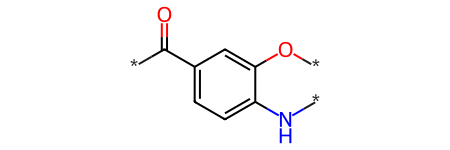

In [7]:
Chem.MolFromSmiles("[*]C(=O)c1ccc(N[*])c(O[*])c1")

We can sketch the scaffold with R-groups in place and save the core with R-groups to a molfile. I sketched this with [Marvin Sketch](https://marvinjs-demo.chemaxon.com/latest/examples/demo.html) but you should be able to use any chemical sketcher. 

In [8]:
mb = """
  Mrv2004 04242220562D          

 13 13  0  0  0  0            999 V2000
   -1.0632    2.0028    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7777    1.5903    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7777    0.7652    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0632    0.3527    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3488    0.7652    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3488    1.5903    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.3321    1.9834    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4922    2.0028    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4922    2.8278    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.3057    0.2630    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.2067    1.5903    0.0000 R#  0  0  0  0  0  0  0  0  0  0  0  0
    1.0466    1.5709    0.0000 R#  0  0  0  0  0  0  0  0  0  0  0  0
    0.3057   -0.5620    0.0000 R#  0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0  0  0  0
  2  3  1  0  0  0  0
  3  4  2  0  0  0  0
  4  5  1  0  0  0  0
  5  6  2  0  0  0  0
  1  6  1  0  0  0  0
  6  7  1  0  0  0  0
  2  8  1  0  0  0  0
  8  9  2  0  0  0  0
  5 10  1  0  0  0  0
  8 11  1  0  0  0  0
  7 12  1  0  0  0  0
 10 13  1  0  0  0  0
M  RGP  3  11   1  12   2  13   3
M  END
"""

We can then convert the molfile to an RDKit molecule. 

In [9]:
core = Chem.MolFromMolBlock(mb)

Here's the core molecule. 

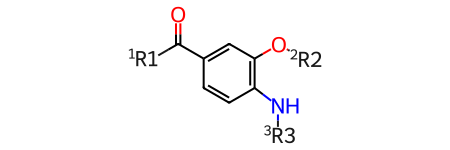

In [10]:
core

Now let's create a new Pandas dataframe from the molecules in cluster 0. 

In [11]:
df_0 = df.query("cluster == 0").copy()

We'll add an index column to keep track of things

In [12]:
df_0['index'] = range(0,len(df_0))

### Perform the R-group Decomposition
As mentioned above, we're using the function [rdRGroupDecomposition.RGroupDecompose](https://www.rdkit.org/docs/source/rdkit.Chem.rdRGroupDecomposition.html) from the RDKit. Note that RDKit returns two values from this function.  

- rgd - a dictionary containing the results of the R-group decomposition. This dictionary has keys containing the core with a key "Core", and the R-groups in keys named "R1", "R2", etc. Each dictionary key links to a list of cores or R-groups corresponding input molecules that matched the core (didn't fail).
- failed - a list containing the indices of molecules that did not match the core.


In [13]:
rgd,failed = rdRGroupDecomposition.RGroupDecompose([core],df_0.mol.values,asRows=False)

[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches
[16:10:50] No core matches


Let's look at the first core, all the rest should be the same. 

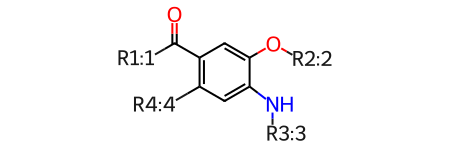

In [14]:
rgd['Core'][0]

Note this core has 4 R-groups, while our input core has 3.  Scroll up and see for yourself.  This is very cool!  The RDKit noticed another point of substitution and added an R-group for us. 

Here are the indices of the molecules that failed. 

In [15]:
failed

[4, 5, 6, 46, 48, 52, 57, 58, 64, 68, 70]

Let's look at the molecules that failed and try to figure out why. These results make sense.  
- Molecule 4 has a **Br** in place of the **O** in the core
- Molecule 5 has a **methyl** in place of the oxygen in the core
- Molecule 6 does not have an **O** connected to the core
- etc

In some cases, we may want to go back and modify our core definition to include these molecules.  In this case, we'll just skip them.

In [16]:
mols2grid.display(df_0.iloc[failed],mol_col="mol",subset=["img","index"])

Now we want to delete the rows corresponding to molecules that failed the R-group decomposition from **df_O**. Since we created **df_O** from **df**, it inherited the original dataframe's index.  We'll call **reset_index** to create a new index that simply numbers the rows from 0 to len(df_0). 

In [17]:
df_0.reset_index(inplace=True)

Delete the failed rows from **df_0**. 

In [18]:
df_0 = df_0.drop(failed,axis=0)

Get the names of the R-groups

In [19]:
r_groups = [x for x in rgd.keys() if x != "Core"]
r_groups

['R1', 'R2', 'R3', 'R4']

Add the SMILES for the R-groups to **df_0**

In [20]:
for r in sorted(r_groups):
    df_0[r] = rgd[r]
    df_0[r] = df_0[r].apply(Chem.MolToSmiles)

#### View the R-groups and Their Frequency
Create an interactive viewer for the R-groups that shows how many times each R-group was used. Use the menu below to toggle between R1, R2, R3, and R4.

In [21]:
@interact(rg=r_groups)
def display_rgroups(rg):
    vc_df = uru.value_counts_df(df_0,rg)
    return mols2grid.display(vc_df,smiles_col=rg,subset=["img","count"])

interactive(children=(Dropdown(description='rg', options=('R1', 'R2', 'R3', 'R4'), value='R1'), Output()), _do…